# Web scraping in Python: gathering and analyzing NBA player stats

Erick Lu

March 22, 2020

## Introduction

In this project, I use Python’s `urllib` and `re` packages to “scrape” ESPN for stats on all the players in the NBA. I then use `pandas` to format the data into a DataFrame, and calculate some interesting statistics.

Web scraping is a useful technique for extracting data from websites that don’t offer formatted, raw data for download. You can write scripts in Python to automate the process of obtaining information from these websites, so that you don’t have to spend hours flipping through each page and copy-pasting.

As an example, I will be scraping data from the rosters of each team in the NBA for data such as age, height, weight, and salary. I will also loop through each individual player's stats page and extract career averages such as points per game, free throw percentages, and more (as of currently, March 2020).

We can use this data to answer questions such as:

* Do factors such as age, height, weight, etc. correlate with player performance? (i.e. does height matter?)
* What is the average salary paid by each team in the NBA, and which player earns the most on each team?
* How much more do better players cost? Can we model the average price of hiring a player given his performance? If so, what is the cost per increase in points per game?

I've also exported the data to a nicely organized csv file, accessible in the [GitHub repo](https://github.com/erilu/web-scraping-NBA-statistics) for this project if you would like to analyze it yourself. You can also run the python script `scrape_nba_player_stats.py` to re-scrape ESPN yourself to obtain up-to-date data.

In the following sections, I will describe how to navigate through ESPN, read the page sources using `urllib`, extract information using `re`, and organize player statistics in `pandas` DataFrames.

## Scrape roster information for each NBA team

We will first take a look at the structure of the website and figure out which web pages we need to scrape information from. The teams page at https://www.espn.com/nba/teams looks like the following:

![ESPN_teams_webpage.png](images/ESPN_teams_webpage.png)

This looks very promising. All the teams are listed on this page, which means that they can easily be extracted from the page source. Let’s take a look at the page source to see if we can find URLs for each team's roster:

![ESPN_teams_source.png](images/ESPN_teams_source.png)

It looks like URLs for each of the teams rosters are listed in the page source with the following format: https://www.espn.com/nba/team/roster/_/name/team/team-name, as shown in the highlighted portion of the image above. Given that these all follow the same format, we can use regular expressions to pull out a list of all the team names from the page source, and then construct the roster URLs using the format above. Start by importing the `urllib` and `re` packages in Python:

In [78]:
import re
import urllib
from time import sleep

Now, let’s create a function that will extract all the team names from http://www.espn.com/nba/teams and construct roster URLs for each of the teams:

In [114]:
# This method finds the urls for each of the rosters in the NBA using regexes.
def build_team_urls():
    # Open the espn teams webpage and extract the names of each roster available.
    f = urllib.request.urlopen('http://www.espn.com/nba/teams')
    teams_source = f.read().decode('utf-8')
    teams = dict(re.findall("www\.espn\.com/nba/team/_/name/(\w+)/(.+?)\",", teams_source))
    # Using the names of the rosters, create the urls of each roster
    roster_urls = []
    for key in teams.keys():
        # each roster webpage follows this general pattern.
        roster_urls.append('http://www.espn.com/nba/team/roster/_/name/' + key + '/' + teams[key])
        teams[key] = str(teams[key])
    return dict(zip(teams.values(), roster_urls))

In [115]:
rosters = build_team_urls()
rosters

{'atlanta-hawks': 'http://www.espn.com/nba/team/roster/_/name/atl/atlanta-hawks',
 'boston-celtics': 'http://www.espn.com/nba/team/roster/_/name/bos/boston-celtics',
 'brooklyn-nets': 'http://www.espn.com/nba/team/roster/_/name/bkn/brooklyn-nets',
 'charlotte-hornets': 'http://www.espn.com/nba/team/roster/_/name/cha/charlotte-hornets',
 'chicago-bulls': 'http://www.espn.com/nba/team/roster/_/name/chi/chicago-bulls',
 'cleveland-cavaliers': 'http://www.espn.com/nba/team/roster/_/name/cle/cleveland-cavaliers',
 'dallas-mavericks': 'http://www.espn.com/nba/team/roster/_/name/dal/dallas-mavericks',
 'denver-nuggets': 'http://www.espn.com/nba/team/roster/_/name/den/denver-nuggets',
 'detroit-pistons': 'http://www.espn.com/nba/team/roster/_/name/det/detroit-pistons',
 'golden-state-warriors': 'http://www.espn.com/nba/team/roster/_/name/gs/golden-state-warriors',
 'houston-rockets': 'http://www.espn.com/nba/team/roster/_/name/hou/houston-rockets',
 'indiana-pacers': 'http://www.espn.com/nba/t

The function `build_team_urls()` returns a dictionary that matches team names with their corresponding roster URL. Given this information, we can systematically loop through all of the rosters and use regular expressions to extract player information for each team.

In order to figure out how to scrape the rosters, let’s take a look at the Golden State Warriors' roster page as an example:

![GSW_roster_webpage.png](images/GSW_roster_webpage.png)

Information for each player is nicely laid out in a table, meaning that the data is likely obtainable using regular expressions. Taking a look at the page source reveals that each player’s name and information are all provided in blocks of what apppear to be `json`, highlighted below:

![GSW_roster_source.png](images/GSW_roster_source.png)

Given the standardized format of the data for each player, this information is indeed extractable using regular expressions. First, we should read in the roster webpage using `urllib.request.urlopen`:

In [6]:
url = "https://www.espn.com/nba/team/roster/_/name/gs/golden-state-warriors"
f = urllib.request.urlopen(url)
roster_source = f.read().decode('utf-8')

Then, we construct the regex that will return information for each of the players on the roster webpage.

In [8]:
player_regex = ('\{\"name\"\:\"(\w+\s\w+)\",\"href\"\:\"http\://www\.espn\.com/nba/player/.*?\",(.*?)\}')
player_regex
player_info = re.findall(player_regex, roster_source)
player_info[0:4]

[('Ky Bowman',
  '"uid":"s:40~l:46~a:4065635","guid":"d0ef63e951bb5f842b7357521697dc62","id":"4065635","height":"6\' 1\\"","weight":"187 lbs","age":22,"position":"PG","jersey":"12","salary":"$350,189","birthDate":"06/17/97","headshot":"https://a.espncdn.com/i/headshots/nba/players/full/4065635.png","lastName":"Ky Bowman","experience":0,"college":"Boston College"'),
 ('Marquese Chriss',
  '"uid":"s:40~l:46~a:3907487","guid":"a320ecf1d6481b7518ddc1dc576c27b4","id":"3907487","height":"6\' 9\\"","weight":"240 lbs","age":22,"position":"C","jersey":"32","salary":"$654,469","birthDate":"07/02/97","headshot":"https://a.espncdn.com/i/headshots/nba/players/full/3907487.png","lastName":"Marquese Chriss","experience":3,"college":"Washington","birthPlace":"Sacramento, CA"'),
 ('Stephen Curry',
  '"uid":"s:40~l:46~a:3975","guid":"5dda51f150c966e12026400b73f34fad","id":"3975","height":"6\' 3\\"","weight":"185 lbs","age":32,"position":"PG","jersey":"30","salary":"$40,231,758","birthDate":"03/14/88","h

As you can see, `player_info` is a list of tuples, in which each player name is paired with a set of information (height, weight, age, etc.) that is organized in `json` format. We can use the `json` package in Python to convert the information into a Python dictionary:

In [9]:
import json
draymond = json.loads("{"+player_info[3][1]+"}")
draymond

{'age': 30,
 'birthDate': '03/04/90',
 'birthPlace': 'Saginaw, MI',
 'college': 'Michigan State',
 'experience': 7,
 'guid': 'de360720e41625f28a6bb5ff82616cb1',
 'headshot': 'https://a.espncdn.com/i/headshots/nba/players/full/6589.png',
 'height': '6\' 6"',
 'id': '6589',
 'jersey': '23',
 'lastName': 'Draymond Green',
 'position': 'PF',
 'salary': '$18,539,130',
 'uid': 's:40~l:46~a:6589',
 'weight': '230 lbs'}

In the example above, all of the pertinent information for Draymond Green is now stored into a Python dictionary named `draymond`. Let's use the snippets of code above to construct a function which loops through each player in a given roster and scrapes their information:

In [47]:
def get_player_info(roster_url):
    f = urllib.request.urlopen(roster_url)
    roster_source = f.read().decode('utf-8')
    sleep(0.5)
    player_regex = ('\{\"name\"\:\"(\w+\s\w+)\",\"href\"\:\"http\://www\.espn\.com/nba/player/.*?\",(.*?)\}')
    player_info = re.findall(player_regex, roster_source)
    player_dict = dict()
    for player in player_info:
        player_dict[player[0]] = json.loads("{"+player[1]+"}")
    return(player_dict)

We can now loop through each team in `rosters` and run `get_player_info()`, storing the output in a dictionary called `all_players`:

In [49]:
all_players = dict()
for team in rosters.keys():
    print("Gathering player info for team: " + team)
    all_players[team] = get_player_info(rosters[team])

Gathering player info for team: boston-celtics
Gathering player info for team: brooklyn-nets
Gathering player info for team: new-york-knicks
Gathering player info for team: philadelphia-76ers
Gathering player info for team: toronto-raptors
Gathering player info for team: chicago-bulls
Gathering player info for team: cleveland-cavaliers
Gathering player info for team: detroit-pistons
Gathering player info for team: indiana-pacers
Gathering player info for team: milwaukee-bucks
Gathering player info for team: atlanta-hawks
Gathering player info for team: charlotte-hornets
Gathering player info for team: miami-heat
Gathering player info for team: orlando-magic
Gathering player info for team: washington-wizards
Gathering player info for team: denver-nuggets
Gathering player info for team: minnesota-timberwolves
Gathering player info for team: oklahoma-city-thunder
Gathering player info for team: portland-trail-blazers
Gathering player info for team: utah-jazz
Gathering player info for team

After running this code, the `all_players` dictionary should be a dictionary of dictionaries of dictionaries. This sounds complicated, but let's walk through what it looks like. The first level of keys should correspond to teams:

In [50]:
all_players.keys()

dict_keys(['boston-celtics', 'brooklyn-nets', 'new-york-knicks', 'philadelphia-76ers', 'toronto-raptors', 'chicago-bulls', 'cleveland-cavaliers', 'detroit-pistons', 'indiana-pacers', 'milwaukee-bucks', 'atlanta-hawks', 'charlotte-hornets', 'miami-heat', 'orlando-magic', 'washington-wizards', 'denver-nuggets', 'minnesota-timberwolves', 'oklahoma-city-thunder', 'portland-trail-blazers', 'utah-jazz', 'golden-state-warriors', 'la-clippers', 'los-angeles-lakers', 'phoenix-suns', 'sacramento-kings', 'dallas-mavericks', 'houston-rockets', 'memphis-grizzlies', 'new-orleans-pelicans', 'san-antonio-spurs'])

Within a team, the keys should correspond to player names. Let's zoom in on the LA Lakers:

In [51]:
all_players["los-angeles-lakers"].keys()

dict_keys(['Kostas Antetokounmpo', 'Avery Bradley', 'Devontae Cacok', 'Alex Caruso', 'Quinn Cook', 'Anthony Davis', 'Jared Dudley', 'Danny Green', 'Dwight Howard', 'LeBron James', 'Kyle Kuzma', 'JaVale McGee', 'Markieff Morris', 'Rajon Rondo', 'Dion Waiters'])

Now we can choose which player to look at. Let's choose LeBron James as an example:

In [53]:
all_players["los-angeles-lakers"]["LeBron James"]

{'age': 35,
 'birthDate': '12/30/84',
 'birthPlace': 'Akron, OH',
 'experience': 16,
 'guid': '1f6592b3ff53d3218dc56038d48c1786',
 'headshot': 'https://a.espncdn.com/i/headshots/nba/players/full/1966.png',
 'height': '6\' 9"',
 'id': '1966',
 'jersey': '23',
 'lastName': 'LeBron James',
 'position': 'SF',
 'salary': '$37,436,858',
 'uid': 's:40~l:46~a:1966',
 'weight': '250 lbs'}

A dictionary with information about LeBron James is returned. We can extract information even more precisely by specifying which field we are interested in. Let's get his salary:

In [54]:
all_players["los-angeles-lakers"]["LeBron James"]["salary"]

'$37,436,858'

In order to make data analysis easier, we can re-format this dictionary into a `pandas` DataFrame. The function `pd.DataFrame.from_dict()` can turn a dictionary of dictionaries into a `pandas` DataFrame, as demonstrated below:

In [88]:
import pandas as pd
gsw = pd.DataFrame.from_dict(all_players["golden-state-warriors"], orient = "index")
gsw

,uid,guid,id,height,weight,age,position,jersey,salary,birthDate,headshot,lastName,experience,college,birthPlace,hand
Alen Smailagic,s:40~l:46~a:4401415,6ed3f8924bfef2e70329ebd6a104ecae,4401415,"6' 10""",215 lbs,19,PF,6,"$898,310",08/18/00,https://a.espncdn.com/i/headshots/nba/players/...,Alen Smailagic,0,NaN,NaN,NaN
Andrew Wiggins,s:40~l:46~a:3059319,064c19d065276a21ca99fdfb296fe05d,3059319,"6' 7""",197 lbs,25,SF,22,"$27,504,630",02/23/95,https://a.espncdn.com/i/headshots/nba/players/...,Andrew Wiggins,5,Kansas,"Thornhill, ON",NaN
Chasson Randle,s:40~l:46~a:2580898,71b7154a3d81842448b623ee3e65d586,2580898,"6' 2""",185 lbs,27,PG,25,NaN,02/05/93,https://a.espncdn.com/i/headshots/nba/players/...,Chasson Randle,2,Stanford,"Rock Island, IL",NaN
Damion Lee,s:40~l:46~a:2595209,41fafb6d47a66d8f79f94161918541a4,2595209,"6' 5""",210 lbs,27,SG,1,"$842,327",10/21/92,https://a.espncdn.com/i/headshots/nba/players/...,Damion Lee,2,Louisville,NaN,L
Draymond Green,s:40~l:46~a:6589,de360720e41625f28a6bb5ff82616cb1,6589,"6' 6""",230 lbs,30,PF,23,"$18,539,130",03/04/90,https://a.espncdn.com/i/headshots/nba/players/...,Draymond Green,7,Michigan State,"Saginaw, MI",NaN
Eric Paschall,s:40~l:46~a:3133817,b67e5e0fa5cb209355845d165a49407e,3133817,"6' 6""",255 lbs,23,PF,7,"$898,310",11/04/96,https://a.espncdn.com/i/headshots/nba/players/...,Eric Paschall,0,Villanova,"North Tarrytown, NY",NaN
Jordan Poole,s:40~l:46~a:4277956,4b0492b5a52f267fe84098ef6d2e2bdf,4277956,"6' 4""",194 lbs,20,SG,3,"$1,964,760",06/19/99,https://a.espncdn.com/i/headshots/nba/players/...,Jordan Poole,0,Michigan,"Milwaukee, WI",B
Kevon Looney,s:40~l:46~a:3155535,10a8e77b877324c69966f0c4618caad6,3155535,"6' 9""",222 lbs,24,PF,5,"$4,464,226",02/06/96,https://a.espncdn.com/i/headshots/nba/players/...,Kevon Looney,4,UCLA,"Milwaukee, WI",NaN
Klay Thompson,s:40~l:46~a:6475,3411530a7ab7e8dce4f165d59a559520,6475,"6' 6""",215 lbs,30,SG,11,"$32,742,000",02/08/90,https://a.espncdn.com/i/headshots/nba/players/...,Klay Thompson,8,Washington State,"Los Angeles, CA",NaN
Ky Bowman,s:40~l:46~a:4065635,d0ef63e951bb5f842b7357521697dc62,4065635,"6' 1""",187 lbs,22,PG,12,"$350,189",06/17/97,https://a.espncdn.com/i/headshots/nba/players/...,Ky Bowman,0,Boston College,NaN,NaN


In the DataFrame above, each of the parameters such as 'age', 'salary', etc. are organized in columns and each player is a row. This makes display of the data much easier to read and understand. Furthermore, it also places null values when pieces of data are missing--for example, Chasson Randle's salary information is missing from the website, so 'NaN' is automatically placed in the DataFrame.

DataFrames allow us to quickly make calculations, sort players based on their stats, and compare stats between teams. To make a DataFrame containing data from all the teams, we will loop through each team in `all_players`, construct DataFrames, label them with a `team` column, and aggregate them into a single DataFrame called `all_players_df`.

In [ ]:
all_players_df = pd.DataFrame()
# loop through each team, create a pandas DataFrame, and append
for team in all_players.keys():
    team_df = pd.DataFrame.from_dict(all_players[team], orient = "index")
    team_df['team'] = team
    all_players_df = all_players_df.append(team_df)

In [130]:
all_players_df.head(5)

,age,birthDate,birthPlace,college,experience,guid,hand,headshot,height,id,jersey,lastName,position,salary,team,uid,weight
Brad Wanamaker,30,07/25/89,"Philadelphia, PA",Pittsburgh,1,5aad35bbbb760e3958107639266768ae,NaN,https://a.espncdn.com/i/headshots/nba/players/...,"6' 3""",6507,9,Brad Wanamaker,PG,"$1,445,697",boston-celtics,s:40~l:46~a:6507,210 lbs
Carsen Edwards,22,03/12/98,"Houston, TX",Purdue,0,4b8ebdfd01221567925035c1e0d0c337,NaN,https://a.espncdn.com/i/headshots/nba/players/...,"5' 11""",4066407,4,Carsen Edwards,PG,"$1,228,026",boston-celtics,s:40~l:46~a:4066407,200 lbs
Daniel Theis,27,04/04/92,Germany,NaN,2,ce75206c087f83ace6f9a8e3efbd9671,NaN,https://a.espncdn.com/i/headshots/nba/players/...,"6' 8""",2451037,27,Daniel Theis,C,"$5,000,000",boston-celtics,s:40~l:46~a:2451037,245 lbs
Enes Kanter,27,05/20/92,Switzerland,Kentucky,8,1e039b407b3daa6eeac69432aa6413fd,NaN,https://a.espncdn.com/i/headshots/nba/players/...,"6' 10""",6447,11,Enes Kanter,C,"$4,767,000",boston-celtics,s:40~l:46~a:6447,250 lbs
Gordon Hayward,30,03/23/90,"Indianapolis, IN",Butler,9,56f675cb8f40a5aaee5f5747ec9099c5,NaN,https://a.espncdn.com/i/headshots/nba/players/...,"6' 7""",4249,20,Gordon Hayward,SF,"$32,700,690",boston-celtics,s:40~l:46~a:4249,225 lbs


Now, `all_players_df` is a DataFrame with all the players in the NBA categorized by team. It contains player information such as age, salary, height, weight, etc. I'll export this data to a csv file, in case you readers out there want to read it in and play around with it yourself.

In [87]:
all_players_df.to_csv("NBA_roster_info_all_players_mar2020.csv")

In [129]:
all_players_df = pd.read_csv("NBA_roster_info_all_players_mar2020.csv", index_col=0)

## Scrape player stats: career averages

We also want to scrape data coresponding to the performance of each player, in terms of points per game, field goal percentage, rebounds per game, etc. Our goal is to append this information to `all_players_df` so that we can compare player performance with traits such as height, salary, etc. We can find performance stats at each player's personal page on ESPN:

![curry_stats_webpage.png](images/curry_stats_webpage.png)

We'll want to extract the career stats in the bottom row, which can be found in the highlighted section of the source code below:

![curry_stats_source.png](images/curry_stats_source.png)

In order to extract the information above for each player in our DataFrame, we can construct URLs for player stats pages using the `id` column. Fortunately, the URL is standardized and very easy to construct. For example, using the `id` value of 3975 for Stephen Curry, the URL to open would be: https://www.espn.com/nba/player/stats/_/id/3975. Below is an example of extracting his career stats using regexes:

In [92]:
url = "https://www.espn.com/nba/player/stats/_/id/3975"
f = urllib.request.urlopen(url)
sleep(0.3)
player_source = f.read().decode('utf-8')
# extract career stats using this regex
stats_regex = ('\[\"Career\",\"\",(.*?)\]\},\{\"ttl\"\:\"Regular Season Totals\"')
career_info = re.findall(stats_regex, player_source)
print(career_info)

['"699","693","34.3","8.1-17.1","47.6","3.6-8.2","43.5","3.7-4.0","90.6","0.7","3.8","4.5","6.6","0.2","1.7","2.5","3.1","23.5"']


We observe that some of the stats are complex and contain non-numerical symbols such as "-". In the example above, the range "3.7-4.0" is for the column "FT", which stands for "Free Throws Made-Attempted Per Game". We should split this up into two categories, "Free Throws Made (FTM)" and "Free Throws Attempted (FTA)", and do the same for field goals and 3 pointers. To do so, we can split the string based on "-" and then un-nest the list. We also need to convert the strings to floating point values.

In [91]:
from itertools import chain
career_info = career_info[0].replace("\"", "").split(",")
career_info = list(chain.from_iterable([i.split("-") for i in career_info]))
career_info = list(map(float,career_info))
print(career_info)

[699.0, 693.0, 34.3, 8.1, 17.1, 47.6, 3.6, 8.2, 43.5, 3.7, 4.0, 90.6, 0.7, 3.8, 4.5, 6.6, 0.2, 1.7, 2.5, 3.1, 23.5]


Now we can loop through each player in `all_players_df`, open their stats webpage, extract their career stats, and store the stats in a separate data frame called `career_stats_df` using the code below:

In [ ]:
career_stats_df = pd.DataFrame(columns = ["GP","GS","MIN","FGM", "FGA","FG%","3PTM","3PTA","3P%","FTM","FTA","FT%","OR","DR","REB","AST","BLK","STL","PF","TO","PTS"])
for player_index in all_players_df.index:
    url = "https://www.espn.com/nba/player/stats/_/id/" + str(all_players_df.loc[player_index]['id'])
    f = urllib.request.urlopen(url)
    sleep(0.3)
    player_source = f.read().decode('utf-8')
    # extract career stats using this regex
    stats_regex = ('\[\"Career\",\"\",(.*?)\]\},\{\"ttl\"\:\"Regular Season Totals\"')
    career_info = re.findall(stats_regex, player_source)
    try:
        # convert the stats to a list of floats, and add the entry to the DataFrame
        career_info = career_info[0].replace("\"", "").split(",")
        career_info = list(chain.from_iterable([i.split("-") for i in career_info]))
        career_info = list(map(float,career_info))
        career_stats_df = career_stats_df.append(pd.Series(career_info, index = career_stats_df.columns, name=player_index))
    except:
        # if no career stats were returned, the player was a rookie with no games played
        print(player_index + " has no info, ", end = "") 

Some player webpages did not have career stats, which I found corresponded to rookies which had no games played. This threw an error in the loop, so I used a try/except clause to bypass the error and continue stripping content for the remaining players. Their stats are currently stored in the object `career_stats_df`:

In [128]:
career_stats_df.head(5)

,GP,GS,MIN,FGM,FGA,FG%,3PTM,3PTA,3P%,FTM,...,FT%,OR,DR,REB,AST,BLK,STL,PF,TO,PTS
Brad Wanamaker,99.0,1.0,15.7,1.9,4.3,44.0,0.5,1.3,38.0,1.3,...,91.7,0.2,1.4,1.7,2.2,0.1,0.6,1.6,0.9,5.6
Carsen Edwards,35.0,0.0,9.0,1.1,3.2,32.7,0.6,1.9,30.9,0.3,...,84.6,0.2,1.1,1.2,0.6,0.1,0.3,0.9,0.4,3.0
Daniel Theis,187.0,62.0,17.2,2.6,4.7,55.4,0.4,1.1,34.0,1.1,...,75.3,1.6,3.1,4.7,1.2,0.9,0.5,2.8,0.7,6.7
Enes Kanter,634.0,222.0,21.8,4.8,8.8,54.2,0.1,0.2,28.7,2.0,...,77.6,2.9,4.7,7.6,0.9,0.5,0.4,2.2,1.5,11.6
Gordon Hayward,634.0,472.0,30.8,5.2,11.6,45.1,1.3,3.6,36.6,3.5,...,82.2,0.7,3.6,4.4,3.5,0.4,1.0,1.7,2.0,15.3


The stats for each player are now organized in a neat DataFrame. Here is a legend for what each of the abbreviations mean:

* GP:Games Played
* GS:Games Started
* MIN:Minutes Per Game
* FGM:Field Goals Made Per Game
* FGA:Field Goals Attempted Per Game
* FG%:Field Goal Percentage
* 3PTM:3-Point Field Goals Made Per Game
* 3PTA:3-Point Field Goals Attempted Per Game
* 3P%:3-Point Field Goal Percentage
* FTM:Free Throws Made Per Game
* FTA:Free Throws Attempted
* FT%:Free Throw Percentage
* OR:Offensive Rebounds Per Game
* DR:Defensive Rebounds Per Game
* REB:Rebounds Per Game
* AST:Assists Per Game
* BLK:Blocks Per Game
* STL:Steals Per Game
* PF:Fouls Per Game
* TO:Turnovers Per Game
* PTS:Points Per Game

I'll also export these stats to a csv file:

In [240]:
career_stats_df.to_csv("NBA_player_stats_all_mar2020.csv")

In [127]:
career_stats_df = pd.read_csv("NBA_player_stats_all_mar2020.csv", index_col=0)

## Joining and cleaning the data

We will now join `career_stats_df` with `all_players_df`, which will merge the content from both data frames based on rows that have the same index (player name). Players in `all_players_df` that are not included in `career_stats_df` will have `NaN` values for the joined columns.

In [131]:
all_stats_df = all_players_df.join(career_stats_df)

In [134]:
all_stats_df.head(5)

,age,birthDate,birthPlace,college,experience,guid,hand,headshot,height,id,...,FT%,OR,DR,REB,AST,BLK,STL,PF,TO,PTS
Brad Wanamaker,30,07/25/89,"Philadelphia, PA",Pittsburgh,1,5aad35bbbb760e3958107639266768ae,NaN,https://a.espncdn.com/i/headshots/nba/players/...,"6' 3""",6507,...,91.7,0.2,1.4,1.7,2.2,0.1,0.6,1.6,0.9,5.6
Carsen Edwards,22,03/12/98,"Houston, TX",Purdue,0,4b8ebdfd01221567925035c1e0d0c337,NaN,https://a.espncdn.com/i/headshots/nba/players/...,"5' 11""",4066407,...,84.6,0.2,1.1,1.2,0.6,0.1,0.3,0.9,0.4,3.0
Daniel Theis,27,04/04/92,Germany,NaN,2,ce75206c087f83ace6f9a8e3efbd9671,NaN,https://a.espncdn.com/i/headshots/nba/players/...,"6' 8""",2451037,...,75.3,1.6,3.1,4.7,1.2,0.9,0.5,2.8,0.7,6.7
Enes Kanter,27,05/20/92,Switzerland,Kentucky,8,1e039b407b3daa6eeac69432aa6413fd,NaN,https://a.espncdn.com/i/headshots/nba/players/...,"6' 10""",6447,...,77.6,2.9,4.7,7.6,0.9,0.5,0.4,2.2,1.5,11.6
Gordon Hayward,30,03/23/90,"Indianapolis, IN",Butler,9,56f675cb8f40a5aaee5f5747ec9099c5,NaN,https://a.espncdn.com/i/headshots/nba/players/...,"6' 7""",4249,...,82.2,0.7,3.6,4.4,3.5,0.4,1.0,1.7,2.0,15.3


The performance stats have been added as columns on the right side of the DataFrame.

We notice that some of the columns which should contain numerical data such as salary, height, and weight are instead considered strings. This is beacuse they contain non-numerical characters (such as '$' and ',' for salary). To be able to compute statistics on these columns, we need to convert them to numeric values.

We can convert salaries to numeric by removing all non-numerical characters and converting to `int` using list comprehension:

In [135]:
# before converting
all_stats_df['salary'].head(3)

Brad Wanamaker    $1,445,697
Carsen Edwards    $1,228,026
Daniel Theis      $5,000,000
Name: salary, dtype: object

In [136]:
all_stats_df['salary']=[int(re.sub(r'[^\d.]+', '', s)) if isinstance(s, str) else s for s in all_stats_df['salary'].values]

In [137]:
# after converting
all_stats_df['salary'].head(3)

Brad Wanamaker    1445697.0
Carsen Edwards    1228026.0
Daniel Theis      5000000.0
Name: salary, dtype: float64

Height is also provided in a non-numeric form, in feet plus inches (e.g. 6' 5"). We should convert this to a numeric form so that statistics can be calculated. To do so, we will write a small function that converts a string of feet plus inches into a numeric value of total inches, `convert_height`.

In [138]:
def convert_height(height):
    split_height = height.split(" ")
    feet = float(split_height[0].replace("\'",""))
    inches = float(split_height[1].replace("\"",""))
    return (feet*12 + inches)

In [139]:
# before conversion
all_stats_df['height'].head(3)

Brad Wanamaker     6' 3"
Carsen Edwards    5' 11"
Daniel Theis       6' 8"
Name: height, dtype: object

In [140]:
all_stats_df['height'] = [convert_height(x) for x in all_stats_df['height']]

In [141]:
# after conversion
all_stats_df['height'].head(3)

Brad Wanamaker    75.0
Carsen Edwards    71.0
Daniel Theis      80.0
Name: height, dtype: float64

Weight is also a non-numerical field, because of the units listed (e.g. weight': '230 lbs'). We will simply strip off the units for each entry by splitting the string in half with `split(" ")` and taking the left side of the split.

In [142]:
# before conversion
all_stats_df['weight'].head(3)

Brad Wanamaker    210 lbs
Carsen Edwards    200 lbs
Daniel Theis      245 lbs
Name: weight, dtype: object

In [143]:
all_stats_df['weight'] = [float(x.split(" ")[0]) for x in all_stats_df['weight']]

In [144]:
# after conversion
all_stats_df['weight'].head(3)

Brad Wanamaker    210.0
Carsen Edwards    200.0
Daniel Theis      245.0
Name: weight, dtype: float64

This should be the last of the values we have to convert to numeric. Now, we have a cleaned-up and joined dataset! I'll save the data to a csv file.

In [146]:
all_stats_df.to_csv("NBA_player_info_and_stats_joined_mar2020.csv")

In [102]:
all_stats_df = pd.read_csv("NBA_player_info_and_stats_joined_mar2020.csv", index_col=0)

## Calculating statistics

We can use the data we just compiled to calculate some statistics. Let's start by calculating average stats per team, using `groupby()` with `mean()` in `pandas`.

In [176]:
# calculate means and remove irrelevant columns for id and jersey #
mean_df = all_stats_df.groupby('team').mean().drop(['id','jersey'],1)
mean_df

,age,experience,height,salary,weight,GP,GS,MIN,FGM,FGA,...,FT%,OR,DR,REB,AST,BLK,STL,PF,TO,PTS
team,,,,,,,,,,,,,,,,,,,,,
atlanta-hawks,25.538462,4.307692,79.000000,5.608001e+06,218.615385,314.153846,200.076923,22.215385,3.815385,8.146154,...,74.423077,1.223077,3.184615,4.407692,2.323077,0.569231,0.669231,2.146154,1.430769,10.300000
boston-celtics,25.000000,2.500000,77.687500,7.228917e+06,224.062500,218.000000,121.687500,17.718750,2.787500,6.212500,...,76.050000,0.712500,2.356250,3.081250,1.562500,0.356250,0.612500,1.631250,1.006250,7.662500
brooklyn-nets,25.882353,4.529412,78.529412,7.928121e+06,217.352941,310.823529,214.000000,20.905882,3.482353,7.652941,...,71.711765,0.864706,2.970588,3.835294,2.047059,0.476471,0.641176,1.688235,1.288235,9.582353
charlotte-hornets,24.266667,2.733333,78.733333,6.772335e+06,216.066667,203.400000,103.466667,19.566667,2.626667,5.973333,...,75.086667,0.933333,2.773333,3.680000,1.506667,0.440000,0.626667,1.746667,1.000000,7.013333
chicago-bulls,24.533333,2.533333,79.000000,5.392607e+06,217.266667,199.400000,105.666667,20.033333,3.100000,6.866667,...,73.613333,0.793333,2.580000,3.360000,1.826667,0.326667,0.726667,1.773333,1.020000,8.180000
cleveland-cavaliers,24.866667,2.933333,78.333333,8.744085e+06,224.333333,253.615385,165.538462,20.376923,3.184615,6.953846,...,62.484615,1.246154,3.069231,4.300000,1.638462,0.353846,0.546154,1.692308,1.200000,8.407692
dallas-mavericks,26.416667,3.250000,79.250000,7.593353e+06,220.333333,237.750000,105.666667,19.083333,3.233333,7.058333,...,70.833333,0.791667,2.725000,3.533333,1.808333,0.466667,0.575000,1.566667,1.033333,8.933333
denver-nuggets,25.928571,4.285714,79.285714,8.798127e+06,224.142857,347.153846,185.307692,20.976923,3.423077,7.330769,...,75.776923,1.061538,2.946154,3.984615,2.030769,0.469231,0.700000,1.846154,1.107692,9.092308
detroit-pistons,24.941176,3.411765,78.000000,6.505785e+06,208.529412,235.058824,132.294118,18.876471,2.911765,6.652941,...,64.917647,0.711765,2.335294,3.029412,1.723529,0.341176,0.517647,1.635294,1.000000,7.900000


As you can see, the index of the data frame that is returned corresponds to each individual team now, and the mean values are displayed for each of the columns with numerical values. To find the team with the highest averages for a specific stat, we can use the `sort_values()` function. Let's find the top 5 teams with the highest average salary:

In [155]:
mean_df.sort_values('salary', ascending=False).head(5)

,age,experience,height,id,jersey,salary,weight,GP,GS,MIN,...,FT%,OR,DR,REB,AST,BLK,STL,PF,TO,PTS
team,,,,,,,,,,,,,,,,,,,,,
golden-state-warriors,25.076923,3.153846,77.538462,2.702354e+06,14.538462,1.173546e+07,209.153846,244.692308,187.692308,24.076923,...,77.800000,0.792308,2.853846,3.661538,2.400000,0.384615,0.784615,2.115385,1.430769,11.123077
orlando-magic,24.833333,3.166667,79.750000,2.539607e+06,14.416667,9.398300e+06,219.083333,234.416667,136.916667,19.333333,...,71.383333,0.966667,2.866667,3.841667,1.458333,0.525000,0.625000,1.575000,0.900000,7.816667
oklahoma-city-thunder,25.066667,3.866667,78.533333,2.935924e+06,14.800000,9.111964e+06,217.000000,281.533333,187.466667,18.613333,...,61.446667,0.793333,2.320000,3.106667,1.566667,0.400000,0.680000,1.673333,0.920000,6.973333
philadelphia-76ers,25.714286,3.714286,78.642857,2.451142e+06,18.857143,8.825191e+06,218.500000,263.214286,156.785714,20.685714,...,67.207143,0.857143,3.164286,4.021429,2.107143,0.571429,0.671429,1.835714,1.314286,9.392857
denver-nuggets,25.928571,4.285714,79.285714,2.803159e+06,16.642857,8.798127e+06,224.142857,347.153846,185.307692,20.976923,...,75.776923,1.061538,2.946154,3.984615,2.030769,0.469231,0.700000,1.846154,1.107692,9.092308


Looks like the highest average salary is paid by the Golden State Warriors. Similarly, we can find the top 10 highest paid players by sorting `all_stats_df` on salary, then pulling out the top entries for the 'salary' and 'team' columns:

In [160]:
all_stats_df.sort_values('salary', ascending=False)[['salary','team']].head(10)

,salary,team
Stephen Curry,40231758.0,golden-state-warriors
Russell Westbrook,38506482.0,houston-rockets
Chris Paul,38506482.0,oklahoma-city-thunder
Kevin Durant,38199000.0,brooklyn-nets
James Harden,38199000.0,houston-rockets
John Wall,38199000.0,washington-wizards
LeBron James,37436858.0,los-angeles-lakers
Kyle Lowry,34996296.0,toronto-raptors
Blake Griffin,34449964.0,detroit-pistons
Kemba Walker,32742000.0,boston-celtics


Stephen Curry is the highest paid player in the NBA with a whopping salary of $40,231,758, followed by Russell Westbrook. We can continue to sift through the data this way for whatever piques our interest. Given how many different variables there are, we can write a small function to make things easier:

In [171]:
def top_n(df, category, n):
    return (df.sort_values(category, ascending=False)[[category,'team']].head(n))

This way, we can quickly identify the top n players for any given category in a DataFrame. Let's cycle through some stats of interest:

In [172]:
top_n(all_stats_df, 'PTS', 5)

,PTS,team
LeBron James,27.1,los-angeles-lakers
Kevin Durant,27.0,brooklyn-nets
James Harden,25.1,houston-rockets
Luka Doncic,24.4,dallas-mavericks
Joel Embiid,24.1,philadelphia-76ers


In [173]:
top_n(all_stats_df, 'REB', 5)

,REB,team
Andre Drummond,13.8,cleveland-cavaliers
Dwight Howard,12.3,los-angeles-lakers
Hassan Whiteside,11.8,portland-trail-blazers
Joel Embiid,11.5,philadelphia-76ers
Kevin Love,11.1,cleveland-cavaliers


In [174]:
top_n(all_stats_df, 'height', 5)

,height,team
Tacko Fall,89.0,boston-celtics
Boban Marjanovic,88.0,dallas-mavericks
Kristaps Porzingis,87.0,dallas-mavericks
Moses Brown,86.0,portland-trail-blazers
Bol Bol,86.0,denver-nuggets


In [175]:
top_n(all_stats_df, 'weight', 5)

,weight,team
Tacko Fall,311.0,boston-celtics
Jusuf Nurkic,290.0,portland-trail-blazers
Boban Marjanovic,290.0,dallas-mavericks
Nikola Jokic,284.0,denver-nuggets
Zion Williamson,284.0,new-orleans-pelicans


Interestingly, Tacko Fall of the Boston Celtics is both the tallest and the heaviest player in the NBA.

To get a high level overview of how each statistic correlates with one another, we can generate a correlation matrix using `corr()` and `matplotlib`.

In [190]:
corr_matrix = all_stats_df.drop(['id','jersey'],1).corr()

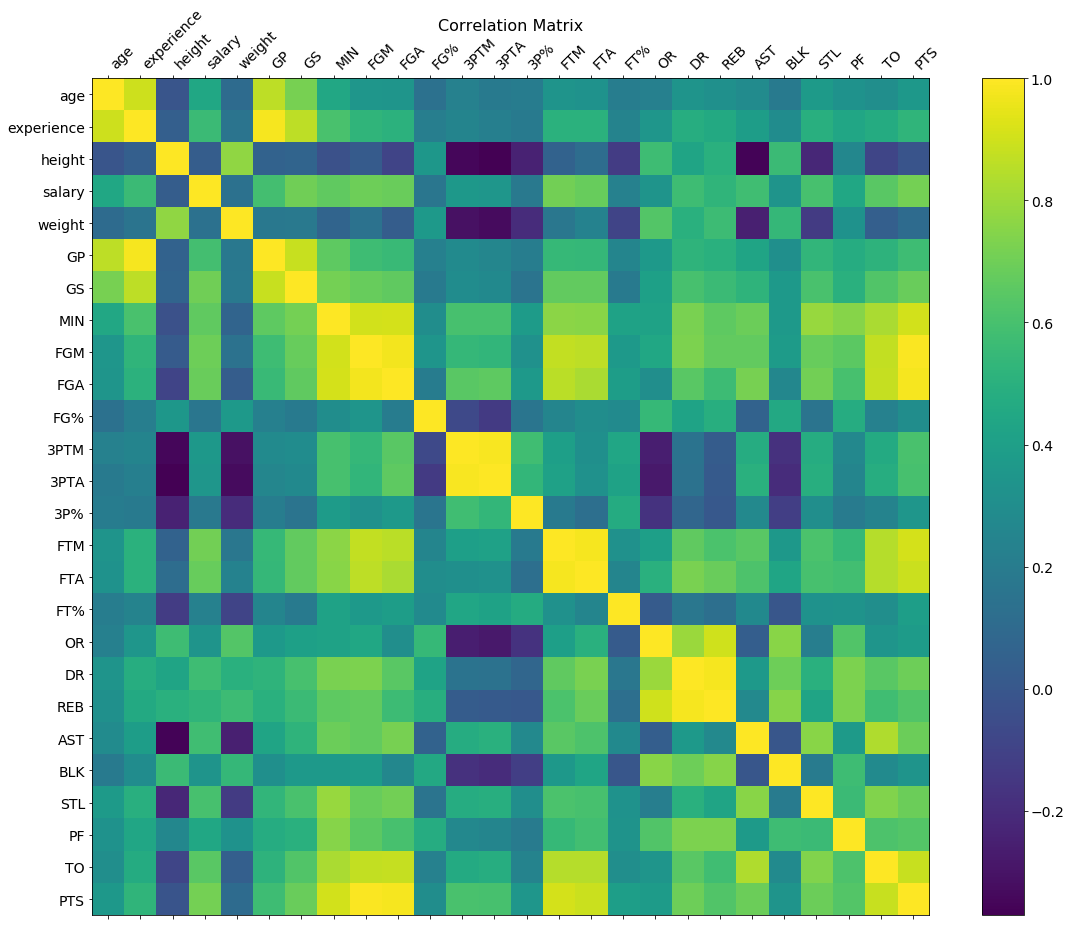

In [191]:
import matplotlib.pyplot as plt

f = plt.figure(figsize=(19, 15))
plt.matshow(corr_matrix, fignum=f.number)
plt.xticks(range(corr_matrix.shape[1]), corr_matrix.columns, fontsize=14, rotation=45, ha = 'left')
plt.yticks(range(corr_matrix.shape[1]), corr_matrix.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

We can learn a lot about how different statistics are associated with each other from this matrix, and also identify some interesting trends. For example:

* As expected, we observe that games played, age, and experience are highly correlated with one another. An older player will have played more games and have more years of experience in the NBA.
* As expected, height is most highly correlated with weight (i.e. taller players weigh more). The correlation of either height or weight with other statistics are similar as well.
* Aside from weight, height is highly correlated with overal offensive rebounds (OR) and blocks (BLK), which also makes sense. A taller player should be able to get these more easily.
* Points per game (PTS) is highly correlated with field goal and free throw attempts, which also makes sense since more shots generally mean more points. Interestingly, the correlation with the percentage made is low.
* One of the highest correlates with salary is points per game, which is one of the more important stats when it comes down to performance.

We can narrow in on correlations of interest by sorting the correlation matrix. Let's try sorting by salary and identifying the top correlates:

In [194]:
corr_matrix.sort_values('salary', ascending=False)['salary'].head(10)

salary    1.000000
PTS       0.712635
FTM       0.707054
GS        0.703869
FGM       0.699154
FGA       0.686631
FTA       0.681934
MIN       0.663697
TO        0.648611
STL       0.602140
Name: salary, dtype: float64

As we suspected, points per game (PTS) is most highly correlated with salary, followed by other point-related stats such as free throws made (FTM). Games started (GS) is also highly correlated with salary, which makes sense since highly-paid players are typically better and will be starters.

## Conclusion

Here, I've used Python to scrape ESPN for statistics on all the players in the NBA using the `urllib` and `re` packages. Then, I used `pandas` to organize the data into a data science-friendly format and calculate some summary statistics.

Again, this is achieved by looping through all the team rosters on the ESPN website, then looping through all the players and extracting their salaries.

In general, webpages that link to subpages within the same site construct their links in some sort of standardized pattern. The techniques that I've outlined here should be broadly applicable for other websites. I hope what you've learned from this project will help you out on your own web scraping quests.

Thanks for reading! I hope my code helped you understand how to perform basic web scraping using Python.